In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from typing import Callable

In [3]:
from torch import distributions

In [4]:
torch.set_default_dtype(torch.float64)

In [5]:
from torch.func import vmap, jacrev

In [6]:
torch.set_num_threads(16)

In [7]:
class ObservableSystem:
    transition: Callable[[torch.Tensor], torch.Tensor]
    observation: Callable[[torch.Tensor], torch.Tensor]
    batch_transition: Callable[[torch.Tensor, float], torch.Tensor]
    batch_observation: Callable[[torch.Tensor, float], torch.Tensor]
    transition_noise: distributions.MultivariateNormal
    observation_noise: distributions.MultivariateNormal
    state: torch.Tensor
    time: float
    dim_state: int
    dim_obs: int

    def __init__(
        self,
        transition: Callable[[torch.Tensor, float], torch.Tensor],
        observation: Callable[[torch.Tensor, float], torch.Tensor],
        transition_noise_cov: torch.Tensor,
        observation_noise_cov: torch.Tensor,
        initial: distributions.MultivariateNormal,
        batch_size: int,
        dt: float
    ) -> None:
        self.transition = transition
        self.batch_transition = vmap(transition)
        self.observation = observation
        self.batch_observation = vmap(observation)
        self.transition_noise = distributions.MultivariateNormal(
            loc=torch.zeros(transition_noise_cov.shape[0]),
            covariance_matrix=transition_noise_cov * dt
        )
        self.observation_noise = distributions.MultivariateNormal(
            loc=torch.zeros(observation_noise_cov.shape[0]),
            covariance_matrix=observation_noise_cov * dt
        )
        self.initial = initial
        self.state = initial.sample((batch_size, ))
        self.dt = dt
        self.time = 0
        self.dim_state = transition_noise_cov.shape[0]
        self.dim_obs = observation_noise_cov.shape[0]
        self.batch_size = batch_size

    def step(self, dt: float | None = None) -> None:
        if dt is None:
            dt = self.dt
        dx = self.batch_transition(self.state) * dt
        dw = self.transition_noise.sample((self.batch_size,))
        self.state += dx + dw

    def observe(self) -> torch.Tensor:
        obs = self.batch_observation(self.state).reshape(self.batch_size, self.dim_obs)
        v = self.observation_noise.sample((self.batch_size, ))
        return obs + v

In [8]:
def fun(x):
    x0 = x * torch.tensor([0.0, 1.0])
    x1 = x * torch.tensor([1.0, 0.0])
    return torch.sin(x1) + x0

f = torch.vmap(fun)
f(torch.tensor(
    [
        [1.0, 2.0],
        [2.0, 3.0],
        [3.0, 4.0]
    ]
))

tensor([[0.8415, 2.0000],
        [0.9093, 3.0000],
        [0.1411, 4.0000]])

In [9]:
from torch.autograd import functional

In [ ]:
class ExtendedKalmanFilter:
    system: ObservableSystem
    dt: float
    order: int
    time: float
    dim_state: int
    dim_obs: int
    batch_size: int

    def __init__(self, system: ObservableSystem, state_cov: torch.Tensor, dt: float, order: int = 1) -> None:
        self.system = system
        self.dim_state = self.system.dim_state
        self.dim_obs = self.system.dim_obs
        self.batch_size = self.system.batch_size
        self.dt = dt
        self.order = order
        self.state = system.initial.mean.reshape(
            1, self.dim_state).repeat(self.batch_size, 1)
        self.state_cov = state_cov.reshape(
            1, state_cov.shape[0], state_cov.shape[1]).repeat(system.batch_size, 1, 1) * self.dt
        self.time = 0
        self.Q = self.system.transition_noise.covariance_matrix / system.dt * self.dt
        self.R = self.system.observation_noise.covariance_matrix / system.dt * self.dt

    def predict(self):
        F = vmap(jacrev(self.system.transition))(self.state).reshape(
            self.batch_size, self.dim_state, self.dim_state) * self.dt
        I = torch.eye(self.dim_state).reshape(1, self.dim_state,
                                              self.dim_state).repeat(self.batch_size, 1, 1)
        F += I
        state = torch.bmm(F, self.state.reshape(
            self.batch_size, self.dim_state, 1)).reshape(self.batch_size, self.dim_state)
        state_cov = torch.bmm(F, self.state_cov).bmm(
            F.transpose(1, 2)) + self.Q.reshape(1, self.dim_state, self.dim_state).repeat(self.batch_size, 1, 1)

        self.state = state
        self.state_cov = state_cov

    def update(self):
        z = self.system.observe().reshape(self.batch_size, self.dim_obs, 1)
        H = vmap(jacrev(self.system.observation))(self.state).reshape(
            self.batch_size, self.dim_obs, self.dim_state)
        y = z - H.bmm(self.state.reshape(self.batch_size,
                      self.dim_state, 1)).reshape(self.batch_size, self.dim_obs, 1)
        S = H.bmm(self.state_cov).bmm(H.transpose(1, 2)) + self.R.reshape(1, self.dim_obs, self.dim_obs).repeat(self.batch_size, 1, 1)

        K = self.state_cov.bmm(H.transpose(1, 2)).bmm(S.inverse())
        self.state += K.bmm(y).reshape(self.batch_size, self.dim_state)
        self.state_cov -= K.bmm(H).bmm(self.state_cov)

In [36]:
predict_freq = 10
update_freq = 100

total_time = 10000

In [37]:
torch.cuda.is_available()

False

In [38]:
torch.set_default_device('cpu')

In [39]:
def transition(x: torch.Tensor):
    L = 0.1
    u1 = 3.0
    u2 = 3.0

    x2 = (torch.tensor([
        [0.0, 0.0, 1.0, 0.0],
    ]) @ x.reshape(x.shape[0], 1)).reshape(1)
    x3 = (torch.tensor([
        [0.0, 0.0, 0.0, 1.0],
    ]) @ x.reshape(x.shape[0], 1)).reshape(1)

    result = torch.zeros_like(x)
    result += torch.torch.tensor([1.0, 0.0, 0.0, 0.0]) * \
        torch.cos(x2) * torch.cos(x3) * u1
    result += torch.tensor([0.0, 1.0, 0.0, 0.0]) * \
        torch.sin(x2) * torch.cos(x3) * u1
    result += torch.tensor([0.0, 0.0, 1.0, 0.0]) * torch.sin(x3) * u1 / L
    result += torch.tensor([0.0, 0.0, 0.0, 1.0]) * u2
    return result

In [40]:
def observation(x: torch.Tensor):
    x0 = x * torch.tensor([1.0, 0.0, 0.0, 0.0])
    x1 = x * torch.tensor([0.0, 1.0, 0.0, 0.0])
    norm = torch.linalg.norm(x0 + x1)
    direction = torch.atan2(x1.sum(), x0.sum())
    
    return torch.tensor([1.0, 0.0]) * norm  + torch.tensor([0.0, 1.0]) * direction

In [41]:
transition_noise_cov = torch.diag(torch.tensor([3e-3, 3e-3, 3e-1, 3e-1]))

In [42]:
observation_noise_cov = torch.eye(2) / 1e2 * 5

In [43]:
T_max = 1.0

In [44]:
initial_distr = distributions.MultivariateNormal(loc=torch.tensor([0.0, 0.0, np.pi / 4, 0.0]), covariance_matrix=torch.eye(4) * 0.0000000004)

In [45]:
batch_size = 10000

In [46]:
system = ObservableSystem(transition, observation, transition_noise_cov, observation_noise_cov, initial_distr, batch_size, T_max / total_time)

In [47]:
state_cov = torch.diag(torch.tensor([3e-3, 3e-3, 3e-1, 3e-1]))

In [48]:
kf = ExtendedKalmanFilter(system, state_cov, T_max / total_time * predict_freq)

In [49]:
from tqdm import tqdm

In [50]:
states = [system.state.detach().cpu().numpy()]

kf_states = [kf.state.detach().cpu().numpy()]
kf_covs = [kf.state_cov.detach().cpu().numpy()]

with torch.no_grad():
    for i in tqdm(range(1, total_time)):
        system.step()
        states.append(system.state.detach().cpu().numpy().copy())
        if i % predict_freq == 0:
            kf.predict()        
            if i % update_freq == 0:
                kf.update()
            kf_states.append(kf.state.detach().cpu().numpy())
            kf_covs.append(kf.state_cov.detach().cpu().numpy())

100%|██████████| 9999/9999 [00:21<00:00, 465.92it/s]


In [51]:
states = np.asarray(states)
kf_states = np.asarray(kf_states)

In [52]:
traj_num = 0

In [53]:
traj = states[:, traj_num, :]
traj_est = kf_states[:, traj_num, :]

In [54]:
t = np.linspace(0, T_max, total_time)
t_est = np.linspace(0, T_max, total_time // predict_freq)

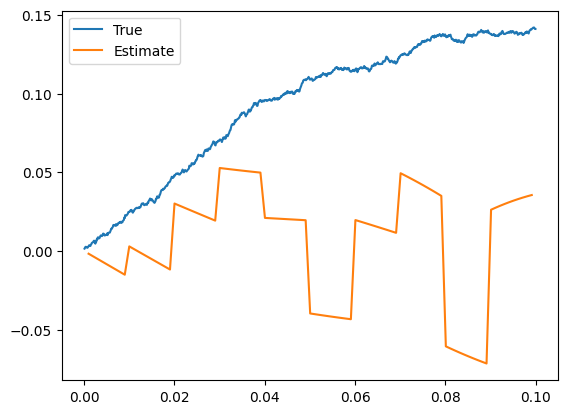

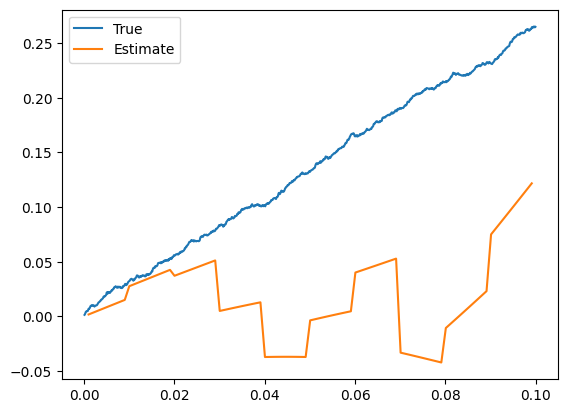

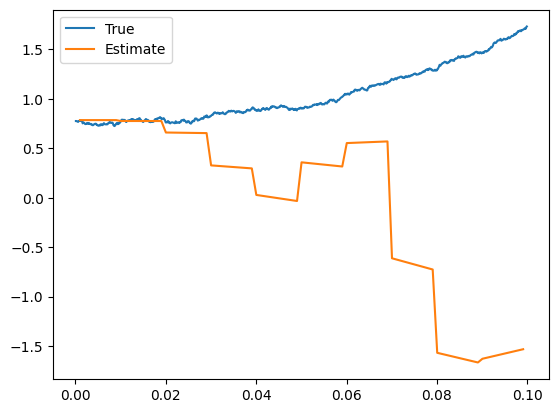

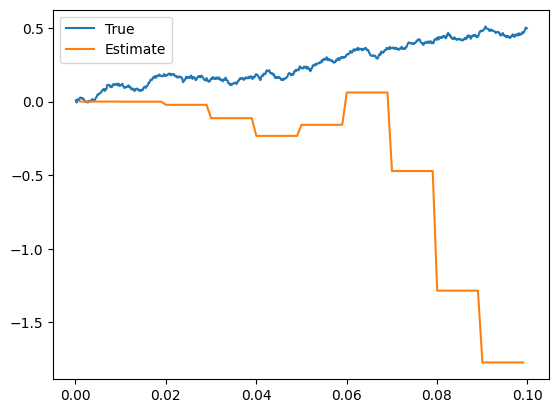

In [55]:
for i in range(4):
    plt.plot(t[1:1000], traj[1:1000, i], label='True')
    plt.plot(t_est[1:100], traj_est[1:100, i], label='Estimate')
    plt.legend()
    plt.show()